In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

#fetching oil data from yahoo finance
data = yf.Ticker('CL=F')
data = yf.download('CL=F', period = 'max')

# Resetting the index to turn the date index into a column
data.reset_index(inplace=True)

data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-23,31.950001,32.799999,31.950001,32.049999,32.049999,79385
1,2000-08-24,31.900000,32.240002,31.400000,31.629999,31.629999,72978
2,2000-08-25,31.700001,32.099998,31.320000,32.049999,32.049999,44601
3,2000-08-28,32.040001,32.919998,31.860001,32.869999,32.869999,46770
4,2000-08-29,32.820000,33.029999,32.560001,32.720001,32.720001,49131
...,...,...,...,...,...,...,...
5909,2024-03-06,78.150002,80.669998,77.989998,79.129997,79.129997,371049
5910,2024-03-07,79.129997,79.529999,78.019997,78.930000,78.930000,432923
5911,2024-03-08,79.510002,79.989998,77.559998,78.010002,78.010002,347533
5912,2024-03-11,77.800003,78.470001,76.790001,77.930000,77.930000,347533


In [2]:
# trim dataset to relevent columns (we only need date and close to forecast prices)
data = data[['Date', 'Close']]
data

,Date,Close
0,2000-08-23,32.049999
1,2000-08-24,31.629999
2,2000-08-25,32.049999
3,2000-08-28,32.869999
4,2000-08-29,32.720001
...,...,...
5909,2024-03-06,79.129997
5910,2024-03-07,78.930000
5911,2024-03-08,78.010002
5912,2024-03-11,77.930000


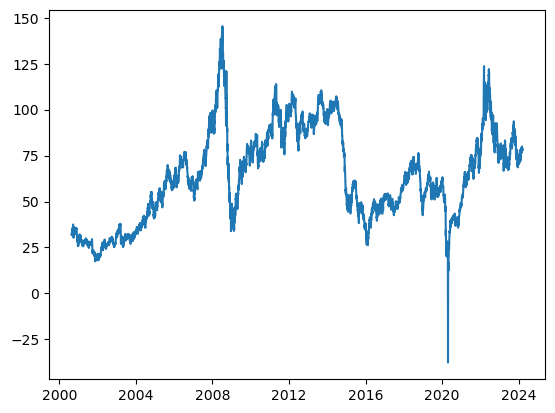

In [3]:
#simple transformations
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
#takes df from above and creates a lookback window of a week (lookback =7) 
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    #shifts dataframe for each lookback window
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-09-01,33.380001,33.099998,33.400002,32.720001,32.869999,32.049999,31.629999,32.049999
2000-09-05,33.799999,33.380001,33.099998,33.400002,32.720001,32.869999,32.049999,31.629999
2000-09-06,34.950001,33.799999,33.380001,33.099998,33.400002,32.720001,32.869999,32.049999
2000-09-07,35.330002,34.950001,33.799999,33.380001,33.099998,33.400002,32.720001,32.869999
2000-09-08,33.700001,35.330002,34.950001,33.799999,33.380001,33.099998,33.400002,32.720001
...,...,...,...,...,...,...,...,...
2024-03-06,79.129997,78.150002,78.739998,79.970001,78.260002,78.540001,78.870003,77.580002
2024-03-07,78.930000,79.129997,78.150002,78.739998,79.970001,78.260002,78.540001,78.870003
2024-03-08,78.010002,78.930000,79.129997,78.150002,78.739998,79.970001,78.260002,78.540001


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[33.38000107, 33.09999847, 33.40000153, ..., 32.04999924,
        31.62999916, 32.04999924],
       [33.79999924, 33.38000107, 33.09999847, ..., 32.86999893,
        32.04999924, 31.62999916],
       [34.95000076, 33.79999924, 33.38000107, ..., 32.72000122,
        32.86999893, 32.04999924],
       ...,
       [78.01000214, 78.93000031, 79.12999725, ..., 79.97000122,
        78.26000214, 78.54000092],
       [77.93000031, 78.01000214, 78.93000031, ..., 78.73999786,
        79.97000122, 78.26000214],
       [77.91000366, 77.93000031, 78.01000214, ..., 78.15000153,
        78.73999786, 79.97000122]])

In [7]:
shifted_df_as_np.shape

(5907, 8)

In [8]:
#runs scaler on data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.22359497, -0.22665644, -0.22337629, ..., -0.23813686,
        -0.24272904, -0.23813686],
       [-0.21900282, -0.22359497, -0.22665644, ..., -0.2291712 ,
        -0.23813686, -0.24272904],
       [-0.206429  , -0.21900282, -0.22359497, ..., -0.23081123,
        -0.2291712 , -0.23813686],
       ...,
       [ 0.26437794,  0.27443697,  0.27662368, ...,  0.28580807,
         0.26711138,  0.27017281],
       [ 0.26350322,  0.26437794,  0.27443697, ...,  0.27235953,
         0.28580807,  0.26711138],
       [ 0.26328459,  0.26350322,  0.26437794, ...,  0.26590866,
         0.27235953,  0.28580807]])

In [9]:
#changes df into x and y
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5907, 7), (5907,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.23813686, -0.24272904, -0.23813686, ..., -0.23081123,
        -0.22337629, -0.22665644],
       [-0.24272904, -0.23813686, -0.2291712 , ..., -0.22337629,
        -0.22665644, -0.22359497],
       [-0.23813686, -0.2291712 , -0.23081123, ..., -0.22665644,
        -0.22359497, -0.21900282],
       ...,
       [ 0.27017281,  0.26711138,  0.28580807, ...,  0.26590866,
         0.27662368,  0.27443697],
       [ 0.26711138,  0.28580807,  0.27235953, ...,  0.27662368,
         0.27443697,  0.26437794],
       [ 0.28580807,  0.27235953,  0.26590866, ...,  0.27443697,
         0.26437794,  0.26350322]])

In [11]:
#use first 95% as train and last 5% as test
split_index = int(len(X) * 0.95)

split_index

5611

In [12]:
# splitting into train and test
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5611, 7), (296, 7), (5611,), (296,))

In [13]:
#PyTorch requires an extra dimension at end
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5611, 7, 1), (296, 7, 1), (5611, 1), (296, 1))

In [14]:
#wrapping in tensors for PyTorch
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5611, 7, 1]),
 torch.Size([296, 7, 1]),
 torch.Size([5611, 1]),
 torch.Size([296, 1]))

In [15]:
#need datasets object for PyTorch
#needs to be custom class
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
# wrap datasets in dataloaders to get batches
# used for iteration
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
#gives predicted outputs of arrays
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
#takes in number of features, dimensions and number of stacked layers (more layers = more complexity in model)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        #initally use 1 layer to prevent overfitting in training data
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        #maps hidden layer to 1. Needed to predict final closing value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #initialise LSTM with default h0 and c0
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        #output is gotten from passing varibles in fully connected layer
        out = self.fc(out[:, -1, :])
        return out

#initial model has 1 input size, 4 hidden sizes and 1 stacked layer
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
#sets model to training mode
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        #puts x and y batch onto device we're using 
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        #comparing model's output to ground truth
        #loss is a tensor with a single value
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        #zero out gradients 
        optimizer.zero_grad()
        #backwards pass 
        loss.backward()
        optimizer.step()

        #every 100 batches get avg loss across batches and print
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
#sets model to validate mode
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        #don't need to calcualte gradient as there's no model updates
        with torch.no_grad():
            output = model(x_batch)
            #compare output to ground truth
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    #average loss value across all batches
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
#10 epochs is all that is necessary as any more will cause overfitting
num_epochs = 10
#trying to minimise mean squared error
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.100
Batch 200, Loss: 0.041
Batch 300, Loss: 0.006

Val Loss: 0.003
***************************************************

Epoch: 2
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002

Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.001

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.000
*****************

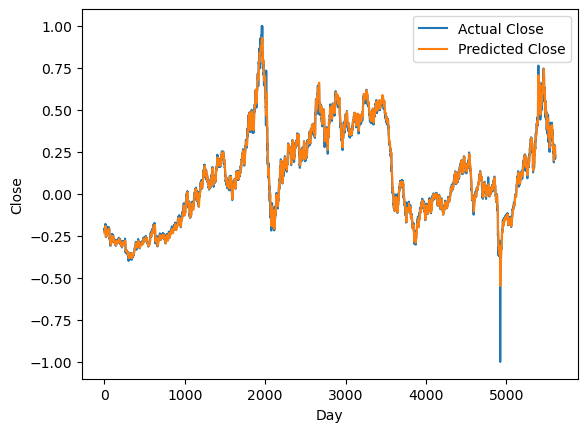

In [23]:
#no gradients for predictions
with torch.no_grad():
    #makes sure it on the device and is put to the CPU (numpy doesn't use GPU)
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
#above data still includes scalar begins at -1
#do opposite of earlier transform
train_predictions = predicted.flatten()

#lookback+1 is the length of the whole dataset
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

#return in right scale
train_predictions = dc(dummies[:, 0])
train_predictions

array([32.58430637, 32.75806559, 33.02513167, ..., 76.27022596,
       75.02336837, 74.34668649])

In [25]:
#first column is no y_train.flatter()
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([33.38000137, 33.79999944, 34.95000129, ..., 73.6699978 ,
       73.76999631, 74.62999786])

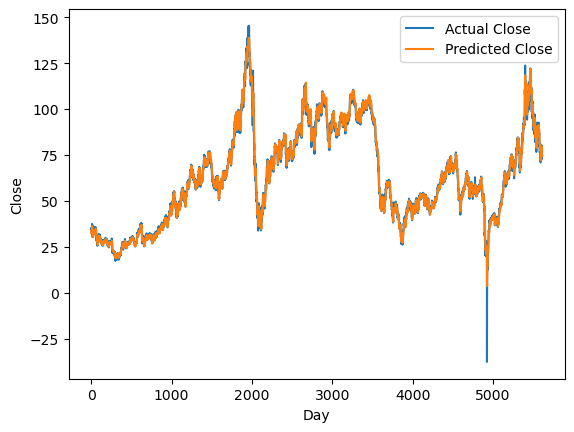

In [26]:
#same graph as earlier with different y_train and predictions
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
#convert to vector of predictions 
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([74.39564861, 74.73853469, 75.97732823, 77.20139063, 78.55214314,
       79.4960083 , 79.73290883, 80.13689329, 80.74958343, 81.26279023,
       80.96587206, 80.7262976 , 80.90006499, 80.48779162, 79.48356811,
       79.21118415, 78.07554004, 77.13075631, 75.53009613, 74.83079623,
       75.72338786, 76.97222569, 77.66573071, 78.74001614, 79.55036189,
       79.55827738, 79.28452783, 79.02163211, 77.9656717 , 77.18951194,
       75.81329439, 75.55231893, 75.85638666, 75.87156483, 76.46708021,
       77.11940641, 77.72424103, 78.69957735, 79.62802584, 79.01040759,
       78.1247611 , 77.11383231, 76.86895633, 76.01018134, 74.06187325,
       71.26195882, 69.77860002, 68.29020408, 67.8539798 , 68.43089486,
       69.57040269, 69.93716062, 69.8178463 , 71.16611432, 72.19068124,
       72.72960113, 73.59611579, 74.65074877, 77.25518817, 79.03474282,
       80.05856154, 80.6104354 , 80.44885743, 80.98258618, 82.02757556,
       82.28950911, 82.55815338, 81.9993589 , 81.58973765, 80.61

In [28]:
#make ground truth proper scale
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([75.12000333, 77.41000363, 78.38999821, 79.86000099, 80.18000055,
       79.48000287, 80.3300024 , 81.30999698, 81.62000405, 80.12999722,
       80.15000128, 81.01000147, 79.67999987, 77.90000092, 78.87000301,
       76.41000363, 75.87999685, 73.38999955, 74.10999993, 77.13999923,
       78.47000083, 78.05999798, 79.72000254, 80.14000061, 79.05999662,
       78.58999522, 78.48999672, 76.33999623, 76.16000328, 73.94999742,
       75.38999956, 76.32000034, 75.67999985, 77.05000412, 77.69000325,
       78.16000466, 79.67999987, 80.46000017, 77.58000136, 76.66000397,
       75.72000116, 76.67999985, 74.8000024 , 71.33000234, 67.61000058,
       68.34999821, 66.73999835, 67.63999986, 69.33000233, 70.90000088,
       69.95999943, 69.26000175, 72.80999761, 73.1999964 , 72.97000148,
       74.37000231, 75.66999782, 80.4199975 , 80.70999779, 80.60999929,
       80.69999712, 79.73999843, 81.52999804, 83.26000183, 82.16000468,
       82.51999602, 80.83000308, 80.85999963, 79.1600033 , 77.29

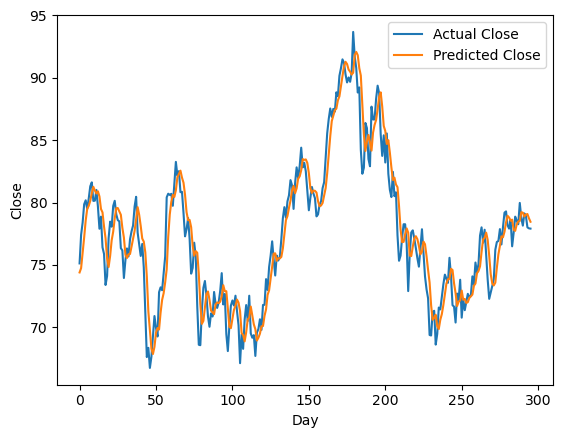

In [29]:
#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [31]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# For each model, replace `actuals` and `predictions` with the corresponding variables
actuals = new_y_test
predictions = test_predictions

# Calculate the RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print("Root Mean Square Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)


Root Mean Square Error (RMSE): 1.9073226916847
Mean Absolute Error (MAE): 1.4999470873549854
Mean Absolute Percentage Error (MAPE): 1.9595749689740154


In [ ]:
#comparing the RMSE, MAE and MAPE for Training vs Validation data to check for overfitting
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).tolist())
            actuals.extend(targets.view(-1).tolist())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    
    return rmse, mae, mape

# Assuming 'train_loader' and 'test_loader' are already defined
# Evaluate the model on training data
train_rmse, train_mae, train_mape = evaluate_model(model, train_loader)
print(f'Training - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, MAPE: {train_mape:.3f}%')

# Evaluate the model on test (validation) data
val_rmse, val_mae, val_mape = evaluate_model(model, test_loader)  # Use test_loader as validation loader
print(f'Validation - RMSE: {val_rmse:.3f}, MAE: {val_mae:.3f}, MAPE: {val_mape:.3f}%')
